# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split



# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Load the dataset

In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [4]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [5]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


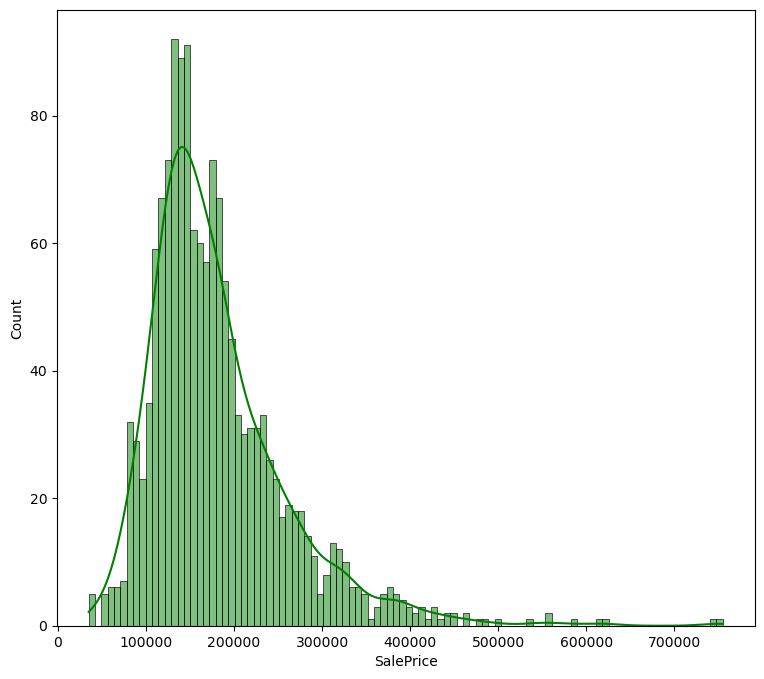

In [7]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], color='g', bins=100, kde=True)

plt.show()

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [8]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

In [9]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

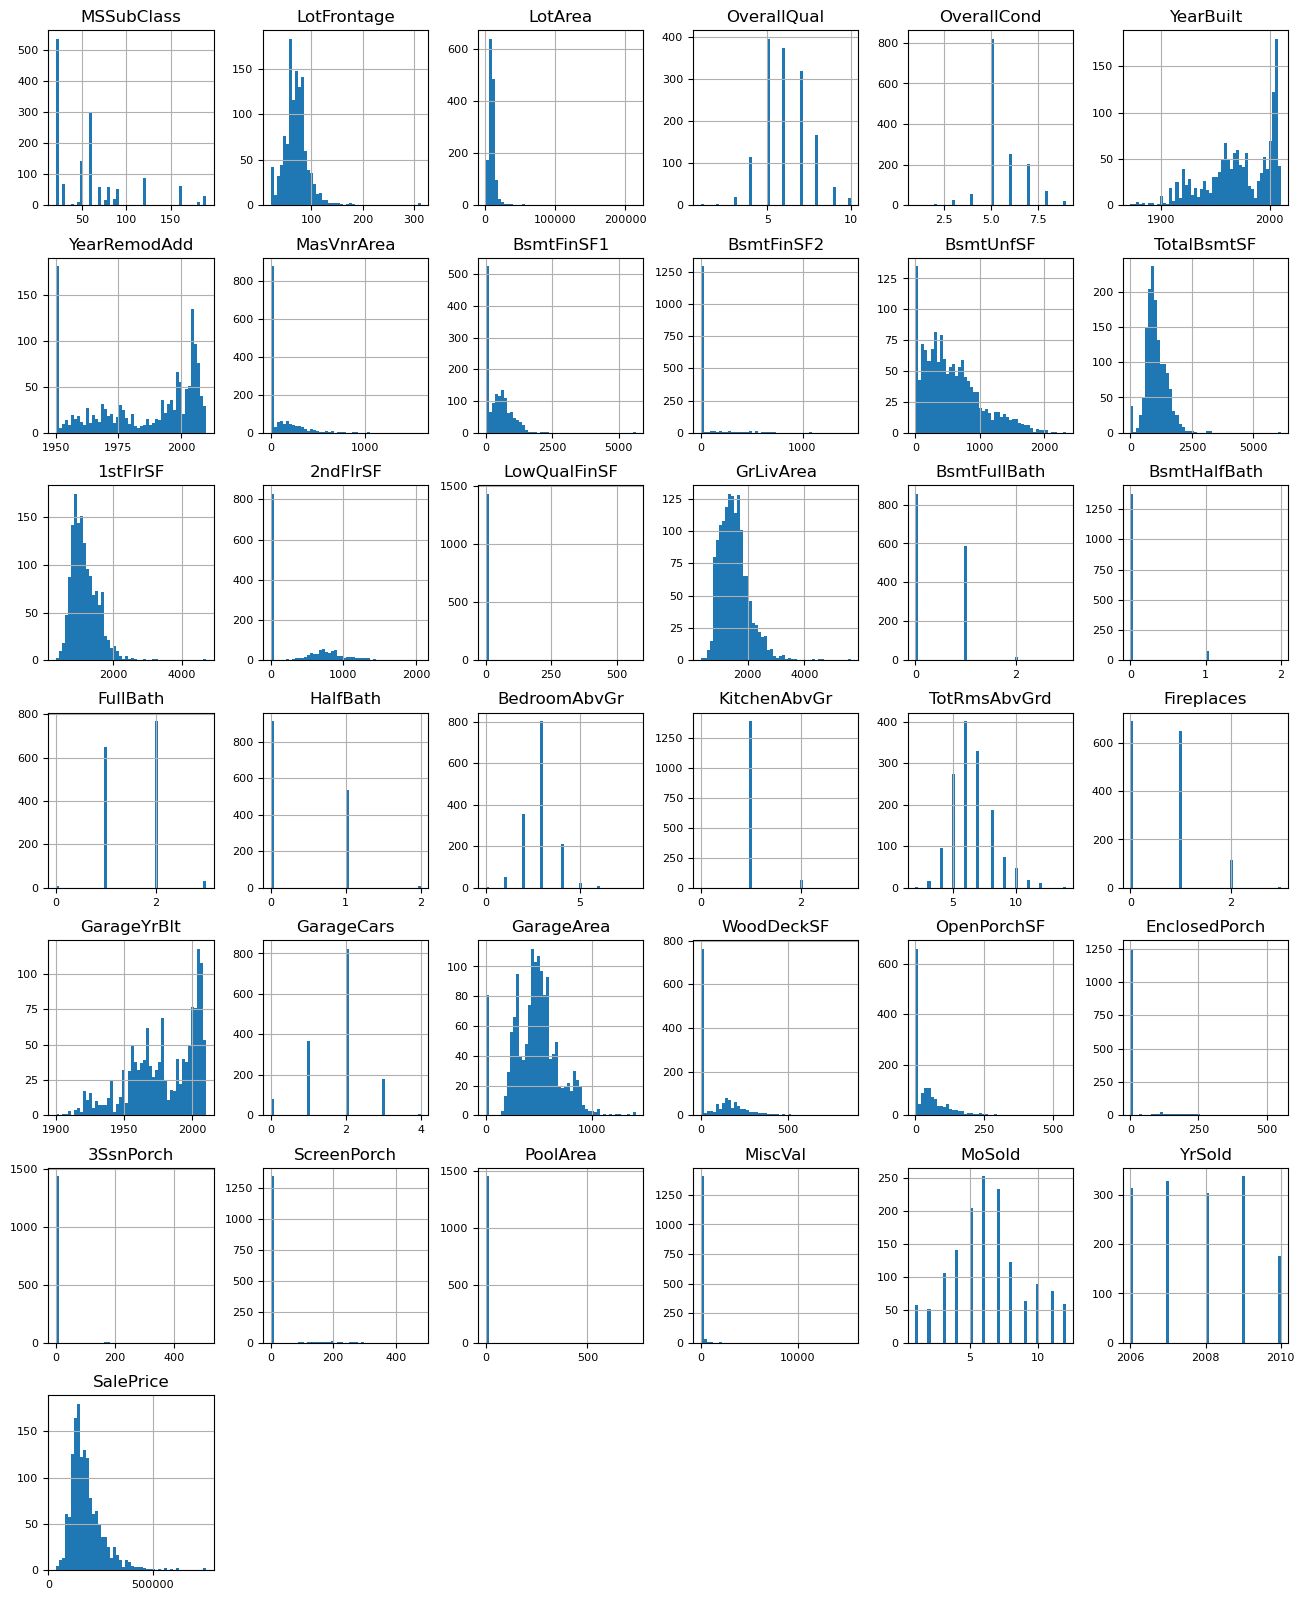

In [10]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [11]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1025 examples in training, 435 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [12]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [13]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [14]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpq7qwkvse as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [15]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.221896. Found 1025 examples.
Training model...


[INFO 2024-11-08T21:11:12.897996263+00:00 kernel.cc:1214] Loading model from path /tmp/tmpq7qwkvse/model/ with prefix 60041d818bda4239


Model trained in 0:00:02.191811
Compiling model...


[INFO 2024-11-08T21:11:13.267703724+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 97526 node(s), and 74 input feature(s).
[INFO 2024-11-08T21:11:13.267782366+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2024-11-08T21:11:13.267830634+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [16]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

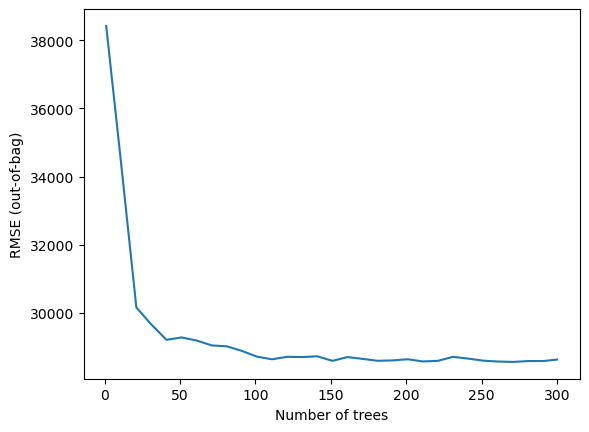

In [17]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [18]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1025, accuracy=None, loss=None, rmse=28634.391619489295, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [19]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 762ms/step - loss: 0.0000e+00 - mse: 945349952.0000
loss: 0.0000
mse: 945349952.0000


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [20]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [21]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 124.0),
 ("ExterQual" (4; #22), 52.0),
 ("Neighborhood" (4; #59), 45.0),
 ("GarageCars" (1; #32), 25.0),
 ("GrLivArea" (1; #38), 24.0),
 ("KitchenQual" (4; #44), 9.0),
 ("YearBuilt" (1; #76), 9.0),
 ("TotalBsmtSF" (1; #73), 3.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("BsmtFinSF1" (1; #8), 2.0),
 ("GarageArea" (1; #31), 2.0),
 ("BsmtQual" (4; #14), 1.0),
 ("GarageFinish" (4; #34), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

Plot the variable importances from the inspector using Matplotlib

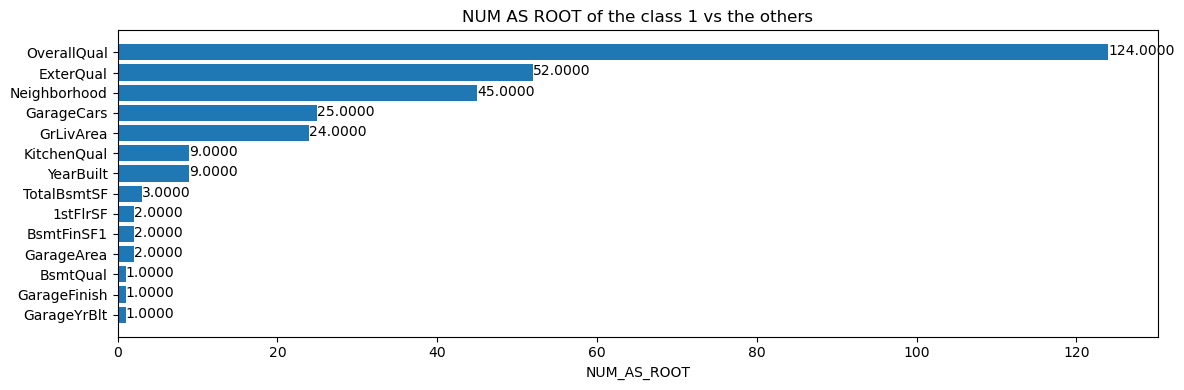

In [22]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [23]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 24ms/step


,Id,SalePrice
0,1461,122690.640625
1,1462,155818.562500
2,1463,183623.593750
3,1464,184356.750000
4,1465,197194.328125


sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

# **Homework 7 (DS6030) - Qais Youssef**

In [25]:
seed = 42
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)

# Drop the 'Id' column
dataset_df = dataset_df.drop('Id', axis=1)

# Apply log transformation to the target variable to stabilize variance
dataset_df['SalePrice'] = np.log1p(dataset_df['SalePrice'])


# Feature Engineering
def create_new_features(df):
    df = df.copy()
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['TotalBath'] = (
        df['FullBath'] + df['HalfBath'] * 0.5 +
        df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5
    )
    return df

dataset_df = create_new_features(dataset_df)


# Split the dataset into training and validation sets
train_ds_pd, valid_ds_pd = train_test_split(
    dataset_df, test_size=0.3, random_state=seed)
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in validation.")

# Handle missing values
numerical_cols = train_ds_pd.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_ds_pd.select_dtypes(include=['object']).columns

# Fill missing values
train_ds_pd[numerical_cols] = train_ds_pd[numerical_cols].fillna(train_ds_pd[numerical_cols].mean())
valid_ds_pd[numerical_cols] = valid_ds_pd[numerical_cols].fillna(train_ds_pd[numerical_cols].mean())

train_ds_pd[categorical_cols] = train_ds_pd[categorical_cols].fillna(train_ds_pd[categorical_cols].mode().iloc[0])
valid_ds_pd[categorical_cols] = valid_ds_pd[categorical_cols].fillna(train_ds_pd[categorical_cols].mode().iloc[0])


# Convert the DataFrames to TensorFlow datasets
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

1022 examples in training, 438 examples in validation.


In [26]:
# Retrain Random Forest with new hyperparameters
rf_new = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=500,
    max_depth=8,    # Reduced from 12
    min_examples=5  # Increased from 2
)
rf_new.compile(metrics=["mse"])
rf_new.fit(x=train_ds)

# Evaluate the new Random Forest model
evaluation_rf = rf_new.evaluate(x=valid_ds, return_dict=True)
print("\nRandom Forest Evaluation on Validation Set:")
for name, value in evaluation_rf.items():
    print(f"{name}: {value:.6f}")

# Define and train Gradient Boosted Trees model
gbt_new = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=500,
    max_depth=6,
    shrinkage=0.005,
    subsample=0.9,
    l2_regularization=0.0
)
gbt_new.compile(metrics=["mse"])
gbt_new.fit(x=train_ds)

# Evaluate Gradient Boosted Trees model
evaluation_gbt = gbt_new.evaluate(x=valid_ds, return_dict=True)
print("\nGradient Boosted Trees Evaluation on Validation Set:")
for name, value in evaluation_gbt.items():
    print(f"{name}: {value:.6f}")

Use /tmp/tmpqx55cqza as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.170046. Found 1022 examples.
Training model...


[INFO 2024-11-08T21:13:31.366193323+00:00 kernel.cc:1214] Loading model from path /tmp/tmpqx55cqza/model/ with prefix 11ce701672be482b


Model trained in 0:00:01.917443
Compiling model...


[INFO 2024-11-08T21:13:31.666821028+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 76914 node(s), and 76 input feature(s).
[INFO 2024-11-08T21:13:31.666900174+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2024-11-08T21:13:31.666956164+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 464ms/step - loss: 0.0000e+00 - mse: 0.0173

Random Forest Evaluation on Validation Set:
loss: 0.000000
mse: 0.017327
Use /tmp/tmp9npeuaaj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.156440. Found 1022 examples.
Training model...
Model trained in 0:00:19.552409
Compiling model...


[INFO 2024-11-08T21:13:53.736625366+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9npeuaaj/model/ with prefix a88818c3c3164222
[INFO 2024-11-08T21:13:53.911440382+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:13:53.911524968+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 465ms/step - loss: 0.0000e+00 - mse: 0.0159

Gradient Boosted Trees Evaluation on Validation Set:
loss: 0.000000
mse: 0.015896


In [27]:
# Prepare the test dataset
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data['Id']
test_data = test_data.drop('Id', axis=1)

test_data = create_new_features(test_data)

# Handle missing values in the test set using training set statistics
numerical_cols = numerical_cols.drop('SalePrice', errors='ignore')  # Exclude target variable
test_data[numerical_cols] = test_data[numerical_cols].fillna(
    train_ds_pd[numerical_cols].mean())
test_data[categorical_cols] = test_data[categorical_cols].fillna(
    train_ds_pd[categorical_cols].mode().iloc[0])

# Convert test data to TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data, task=tfdf.keras.Task.REGRESSION)

# Generate predictions on test data
rf_preds_log = rf_new.predict(test_ds).squeeze()
gbt_preds_log = gbt_new.predict(test_ds).squeeze()

2/2 [==============================] - 1s 40ms/step


In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

seed = 42
# Function to create a new Random Forest model
def create_rf_model():
    rf_model = tfdf.keras.RandomForestModel(
        task=tfdf.keras.Task.REGRESSION,
        num_trees=500,
        max_depth=8,
        min_examples=5
    )
    rf_model.compile(metrics=["mse"])
    return rf_model

# Function to create a new Gradient Boosted Trees model
def create_gbt_model():
    gbt_model = tfdf.keras.GradientBoostedTreesModel(
        task=tfdf.keras.Task.REGRESSION,
        num_trees=500,
        max_depth=6,
        shrinkage=0.005,
        subsample=0.9,
        l2_regularization=0.0
    )
    gbt_model.compile(metrics=["mse"])
    return gbt_model
    
def get_oof_predictions(model_builder, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof_preds = np.zeros(len(X))
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train = y.iloc[train_index]

        # Convert to TensorFlow datasets
        train_ds_fold = tfdf.keras.pd_dataframe_to_tf_dataset(
            X_train.assign(SalePrice=y_train),
            label='SalePrice',
            task=tfdf.keras.Task.REGRESSION
        )
        val_ds_fold = tfdf.keras.pd_dataframe_to_tf_dataset(
            X_val,
            task=tfdf.keras.Task.REGRESSION
        )

        # Create a new model instance for each fold
        model = model_builder()

        # Train model on fold
        model.fit(x=train_ds_fold)

        # Predict on validation fold
        val_preds = model.predict(val_ds_fold).squeeze()
        oof_preds[val_index] = val_preds

    return oof_preds


# Prepare data for meta-learner
X = train_ds_pd.drop('SalePrice', axis=1)
y = train_ds_pd['SalePrice']

# Get OOF predictions for both models using the model builders
rf_oof_preds = get_oof_predictions(create_rf_model, X, y)
gbt_oof_preds = get_oof_predictions(create_gbt_model, X, y)

# Stack predictions
meta_X = np.vstack((rf_oof_preds, gbt_oof_preds)).T
meta_y = y.values

# Train meta-learner
meta_learner = Ridge()
meta_learner.fit(meta_X, meta_y)

# Prepare test predictions for meta-learner
meta_test_X = np.vstack((rf_preds_log, gbt_preds_log)).T

# Predict with meta-learner
final_preds_log = meta_learner.predict(meta_test_X)
final_preds = np.expm1(final_preds_log)

# Prepare submission
submission = pd.DataFrame({'Id': ids, 'SalePrice': final_preds})
submission.to_csv('submission_stacked.csv', index=False)

# Preview the submission file
print("\nStacked Model Submission Preview:")
print(submission.head())

Use /tmp/tmpaaf9ib9d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.246521. Found 817 examples.
Training model...


[INFO 2024-11-08T21:17:45.636917434+00:00 kernel.cc:1214] Loading model from path /tmp/tmpaaf9ib9d/model/ with prefix becf595f55dd4680


Model trained in 0:00:01.617444
Compiling model...


[INFO 2024-11-08T21:17:45.896763839+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 69052 node(s), and 75 input feature(s).
[INFO 2024-11-08T21:17:45.896840318+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2024-11-08T21:17:45.896893084+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 225ms/step
Use /tmp/tmpdqmp4bh2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.139310. Found 817 examples.
Training model...


[INFO 2024-11-08T21:17:49.815474481+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdqmp4bh2/model/ with prefix 1b41c608f71c4c6b


Model trained in 0:00:01.596524
Compiling model...


[INFO 2024-11-08T21:17:50.083182417+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 70532 node(s), and 74 input feature(s).
[INFO 2024-11-08T21:17:50.083261911+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 220ms/step
Use /tmp/tmpd0f812dh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.117612. Found 818 examples.
Training model...


[INFO 2024-11-08T21:17:53.991341438+00:00 kernel.cc:1214] Loading model from path /tmp/tmpd0f812dh/model/ with prefix 6cea5157db874fbf


Model trained in 0:00:01.605922
Compiling model...


[INFO 2024-11-08T21:17:54.256669348+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 69604 node(s), and 77 input feature(s).
[INFO 2024-11-08T21:17:54.256753247+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 222ms/step
Use /tmp/tmphpidhoxw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.139972. Found 818 examples.
Training model...


[INFO 2024-11-08T21:17:58.159715603+00:00 kernel.cc:1214] Loading model from path /tmp/tmphpidhoxw/model/ with prefix b3bacc2006554331


Model trained in 0:00:01.582563
Compiling model...


[INFO 2024-11-08T21:17:58.426963574+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 69852 node(s), and 77 input feature(s).
[INFO 2024-11-08T21:17:58.427025021+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2024-11-08T21:17:58.427062803+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 217ms/step
Use /tmp/tmpa2g1gz9t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.149415. Found 818 examples.
Training model...


[INFO 2024-11-08T21:18:02.381984124+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa2g1gz9t/model/ with prefix 5eca3efd1b95435f


Model trained in 0:00:01.614265
Compiling model...


[INFO 2024-11-08T21:18:02.650347397+00:00 decision_forest.cc:661] Model loaded with 500 root(s), 70136 node(s), and 79 input feature(s).
[INFO 2024-11-08T21:18:02.650444666+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 220ms/step
Use /tmp/tmpt8rvrom4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.137168. Found 817 examples.
Training model...


[INFO 2024-11-08T21:18:32.961641238+00:00 kernel.cc:1214] Loading model from path /tmp/tmpt8rvrom4/model/ with prefix 6a9dc19835224118


Model trained in 0:00:27.907719
Compiling model...


[INFO 2024-11-08T21:18:33.227069766+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:18:33.227138532+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 223ms/step
Use /tmp/tmpk9i22v3s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.167483. Found 817 examples.
Training model...


[INFO 2024-11-08T21:18:57.492192601+00:00 kernel.cc:1214] Loading model from path /tmp/tmpk9i22v3s/model/ with prefix 61cdc562dc1040b9


Model trained in 0:00:21.754896
Compiling model...


[INFO 2024-11-08T21:18:57.695184625+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:18:57.695272162+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 226ms/step
Use /tmp/tmpygepj0lx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.128867. Found 818 examples.
Training model...


[INFO 2024-11-08T21:19:24.235775354+00:00 kernel.cc:1214] Loading model from path /tmp/tmpygepj0lx/model/ with prefix 1f16a1718de84594


Model trained in 0:00:23.532521
Compiling model...


[INFO 2024-11-08T21:19:24.438249061+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:19:24.438332835+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 222ms/step
Use /tmp/tmpvg73a7fw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.096336. Found 818 examples.
Training model...


[INFO 2024-11-08T21:19:53.967333146+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvg73a7fw/model/ with prefix 997a6cb43c3342cf


Model trained in 0:00:27.184659
Compiling model...


[INFO 2024-11-08T21:19:54.212467532+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:19:54.212550967+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 222ms/step
Use /tmp/tmpgs843ca1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.106319. Found 818 examples.
Training model...


[INFO 2024-11-08T21:20:25.080111589+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgs843ca1/model/ with prefix b03edfafbfc7402d


Model trained in 0:00:28.539159
Compiling model...


[INFO 2024-11-08T21:20:25.362396039+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-11-08T21:20:25.362463202+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 228ms/step

Stacked Model Submission Preview:
     Id      SalePrice
0  1461  121463.557881
1  1462  155270.466256
2  1463  189312.988351
3  1464  185700.468167
4  1465  198442.291815


In [31]:
print(submission.isnull().sum())
print(submission['SalePrice'].describe())
print(submission.dtypes)
print(submission.shape)

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_error

# Predictions on the validation set
gbt_valid_preds = gbt_new.predict(valid_ds).squeeze()

# Compute RMSE in log scale
gbt_rmse_log = np.sqrt(mean_squared_error(valid_ds_pd['SalePrice'], gbt_valid_preds))
print(f"Gradient Boosted Trees RMSE (log scale): {gbt_rmse_log}")

# Compute RMSE in original scale
gbt_valid_preds_orig = np.expm1(gbt_valid_preds)
y_valid_orig = np.expm1(valid_ds_pd['SalePrice'].values)
gbt_rmse = np.sqrt(mean_squared_error(y_valid_orig, gbt_valid_preds_orig))
print(f"Gradient Boosted Trees RMSE (original scale): {gbt_rmse}")

# Display first few predictions and true values
print("First 5 GBT Predictions (log scale):", gbt_valid_preds[:5])
print("First 5 True Values (log scale):", valid_ds_pd['SalePrice'].values[:5])

# Convert to original scale
print("First 5 GBT Predictions (original scale):", gbt_valid_preds_orig[:5])
print("First 5 True Values (original scale):", y_valid_orig[:5])

Id           0
SalePrice    0
dtype: int64
count      1459.000000
mean     178122.223681
std       75831.087078
min       51773.150579
25%      127209.829125
50%      155285.043504
75%      207125.188001
max      550483.632664
Name: SalePrice, dtype: float64
Id             int64
SalePrice    float64
dtype: object
(1459, 2)
1/1 [==============================] - 0s 72ms/step
Validation RMSE: 198425.46926095925
Random Forest RMSE (log scale): 0.13673382315425933
Gradient Boosted Trees RMSE (log scale): 12.019818550224379
Random Forest RMSE (original scale): 29180.77735414239
Gradient Boosted Trees RMSE (original scale): 198446.13115645133
